# AOS_ingest_comcam_Gen3

In [1]:
path_to_raws = '/project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/'

In [1]:
ttl_time = 2.12134134124312333
print(f"Repackaging took {ttl_time:.3f}")

Repackaging took 2.121


In [3]:
telcode = 'MC'
CONTRLLR = 'H'
DAYOBS = '20210314'
SEQNUM = 6001
OBSID = "%s_%s_%s_%s" % (
            telcode,
            CONTRLLR,
            DAYOBS,
            str(SEQNUM).zfill(6),
        )
print(OBSID)

OBSID = f"{telcode}_{CONTRLLR}_{DAYOBS}_{SEQNUM:06d}"
print(OBSID)

MC_H_20210314_006001
MC_H_20210314_006001


Use Bryce's Gen3 notebook to ingest, do ISR, and see if it worked ... 

## First, run on LsstCam  R22_S12  : MC_H_.... R22...

I try the following for the LsstCam data  (using comCam where I ran the R22 of LsstCam):

    cd /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/gen3repo/

    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstCam
    butler ingest-raws DATA /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S12.fits 


yields 


    ingest INFO: Successfully extracted metadata from 1 file with 0 failures
    ingest INFO: Exposure LSSTCam:9006001 ingested successfully
    ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
    ingest INFO: Ingested 1 distinct Butler dataset


Then 

    butler define-visits DATA/ lsst.obs.lsst.LsstCam

yields 

    defineVisits INFO: Preprocessing data IDs.
    defineVisits INFO: Registering visit_system 1: by-group-metadata.
    defineVisits INFO: Grouping 1 exposure(s) into visits.
    defineVisits INFO: Computing regions and other metadata for 1 visit(s).

And 

    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstCam
    
And with the following in `testPipeline.yaml` : 

      description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True


I run 

    pipetask run -j 9 -b DATA/ -i LSSTCam/raw/all,LSSTCam/calib \
    -p testPipeline.yaml --register-dataset-types --output-run run1
    
    
And I get 

    ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1616105871.3013885-14022'
    conda.common.io INFO: overtaking stderr and stdout
    conda.common.io INFO: stderr and stdout yielding back
    py.warnings WARN: /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/ip_isr/21.0.0-6-g4e60332+f9e79554c4/python/lsst/ip/isr/isrTask.py:1319: FutureWarning: Call to deprecated method getFilter. (Replaced by getFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
      filterName = afwImage.Filter(ccdExposure.getFilter().getId()).getName()  # Canonical name for filter

    py.warnings WARN: /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/ip_isr/21.0.0-6-g4e60332+f9e79554c4/python/lsst/ip/isr/isrTask.py:1319: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
      filterName = afwImage.Filter(ccdExposure.getFilter().getId()).getName()  # Canonical name for filter

    isr INFO: Converting exposure to floating point values.
    isr INFO: Assembling CCD from amplifiers.
    isr INFO: Widening saturation trails.
    isr INFO: Applying gain correction instead of flat.
    py.warnings WARN: /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/ip_isr/21.0.0-6-g4e60332+f9e79554c4/python/lsst/ip/isr/isrTask.py:2466: FutureWarning: Call to deprecated method getFilter. (Replaced by getFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
      filterName = afwImage.Filter(exposure.getFilter().getId()).getName()  # Canonical name for filter

    py.warnings WARN: /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/ip_isr/21.0.0-6-g4e60332+f9e79554c4/python/lsst/ip/isr/isrTask.py:2466: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
      filterName = afwImage.Filter(exposure.getFilter().getId()).getName()  # Canonical name for filter

    isr WARN: No rough magnitude zero point set for filter g.
    isr INFO: Setting rough magnitude zero point: 28.000000
    ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 95, exposure: 4000021706001, ...} took 9.890 seconds
    ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 0 remain out of total 1 quanta.

Check whether the updated read noise  / gain were used: 

In [1]:
from astropy.io import fits
path_to_file = '/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S12.fits'
hdul =  fits.open(path_to_file)

In [3]:
hdul[1].header['GAIN']

1.1218

In [4]:
hdul[1].header['AMPID']

'C10'

Compare to the (now all updated) values in obs_lsst: 

In [5]:
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
detector = camera['R22_S12']
amp = detector['C10']
print(amp.getGain())

1.14819


I show the postISR images:

In [25]:

from lsst.daf import butler as dafButler
path_to_repo = '/project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/gen3repo/DATA'
butler_lsstCam = dafButler.Butler(path_to_repo)

In [26]:
registry = butler_lsstCam.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)


In [27]:

for x in registry.queryCollections():
    print(x)

LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
run1


In [28]:

datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())

{instrument: 'LSSTCam', detector: 95, exposure: 4000021706001, ...}
{instrument, detector, exposure}


In [29]:
dataId_lsstCam = datasetRefs[0].dataId

In [30]:
postIsrExp_lsstCam = butler_lsstCam.get('postISRCCD', dataId=dataId_lsstCam, collections=['run1'])

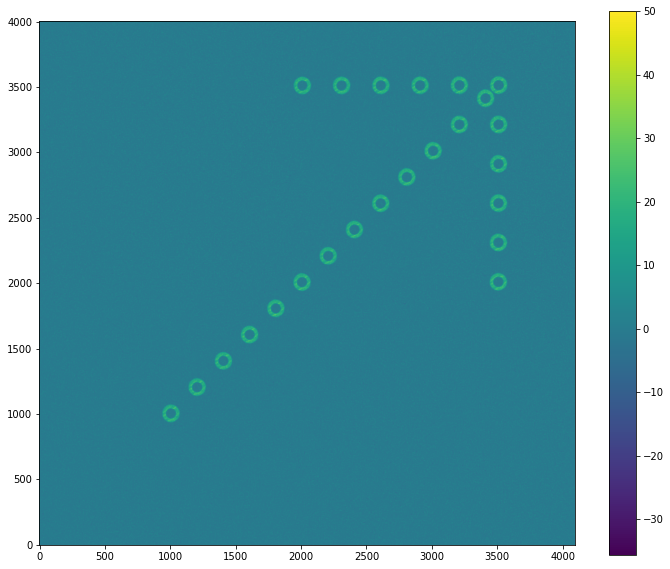

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp_lsstCam.image.array, origin='lower', vmax=50)
plt.colorbar()

Copy the source catalog to plot the stars: 

scp suberlak@epyc.astro.washington.edu:/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_arrow/skyComcamArrows.txt /project/scichris/aos/segmentation_update/comcam/

(array([2.930000e+02, 5.312600e+04, 1.448551e+06, 7.147907e+06,
        6.493907e+06, 1.151492e+06, 8.615300e+04, 1.721400e+04,
        1.687000e+03, 5.400000e+01]),
 array([-35.635227  , -26.520254  , -17.405281  ,  -8.290308  ,
          0.82466507,   9.939638  ,  19.054611  ,  28.169584  ,
         37.284557  ,  46.39953   ,  55.514503  ], dtype=float32),
 <BarContainer object of 10 artists>)

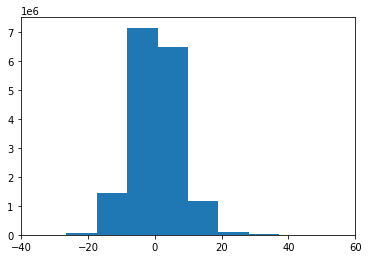

In [21]:
import numpy as np
plt.hist(np.ravel(postIsrExp_lsstCam.image.array))

    astrometadata -p lsst.obs.lsst.translators translate  /project/scichris/aos/segmentation_update/comcam/arrowsUpdSerial2/repackaged/MC_H_20000217_006001_R22_S12.fits 

# Try corner sensor data  (WFS) : MC_H....SW...

Corner sensors used the same `data/lsst` segmentation.txt and focalplanelayout, but they all have different orientations. Still uses the same instrument as FAM : `lsstCam` 

    cd /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd
    mkdir gen3repo
    
    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstCam
    butler ingest-raws DATA /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/repackaged/* 


yields 


    ingest INFO: Successfully extracted metadata from 8 files with 0 failures
    ingest INFO: Exposure LSSTCam:9006002 ingested successfully
    ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
    ingest INFO: Ingested 8 distinct Butler datasets

Then 

    butler define-visits DATA/ lsst.obs.lsst.LsstCam
  
yields an error:

    defineVisits INFO: Preprocessing data IDs.
    defineVisits INFO: Registering visit_system 1: by-group-metadata.
    defineVisits INFO: Grouping 1 exposure(s) into visits.
    defineVisits INFO: Computing regions and other metadata for 1 visit(s).
    Traceback (most recent call last):
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/daf_butler/21.0.0-49-ge0e32052+e6fd6d9ff9/bin/butler", line 28, in <module>
        sys.exit(main())
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/daf_butler/21.0.0-49-ge0e32052+e6fd6d9ff9/python/lsst/daf/butler/cli/butler.py", line 319, in main
        return cli()
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 829, in __call__
        return self.main(*args, **kwargs)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 782, in main
        rv = self.invoke(ctx)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 1259, in invoke
        return _process_result(sub_ctx.command.invoke(sub_ctx))
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 1066, in invoke
        return ctx.invoke(self.callback, **ctx.params)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 610, in invoke
        return callback(*args, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/cli/cmd/commands.py", line 94, in define_visits
        script.defineVisits(*args, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/script/defineVisits.py", line 61, in defineVisits
        task.run(butler.registry.queryDataIds(["exposure"], dataId={"instrument": instr.getName()}),
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 548, in run
        for visitRecords in allRecords:
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 467, in _buildVisitRecordsSingle
        return self._buildVisitRecords(args[0], collections=args[1])
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 361, in _buildVisitRecords
        visitRegion, visitDetectorRegions = self.computeVisitRegions.compute(definition,
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 786, in compute
        detectorBounds = self.computeExposureBounds(visit.exposures[0], collections=collections)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 733, in computeExposureBounds
        orientation = lsst.geom.Angle(exposure.sky_angle, lsst.geom.degrees)
    TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
        1. lsst.geom.Angle(val: float, units: lsst.geom.AngleUnit = <lsst.geom.AngleUnit object at 0x7fe3c520fb70>)
        2. lsst.geom.Angle()

    Invoked with: None, <lsst.geom.AngleUnit object at 0x7fe3a22507f0>

Try the translator:

    astrometadata -p lsst.obs.lsst.translators translate /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/repackaged/MC_H_20000217_006002_R00_SW0.fits 

Perhaps need to repackage with the newest repackager, and ensure that we're using updated `obs_lsst`:

    cd /project/scichris/dev/obs_lsst
    setup -k -r .
    
    phosim_repackager.py /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/ --out_dir /project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/repackaged2/  --verbose


ok - that worked! So continue with ISR:

And 

    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstCam
    
And with the following in `testPipeline.yaml` : 

      description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True


I run 

    pipetask run -j 9 -b DATA/ -i LSSTCam/raw/all,LSSTCam/calib \
    -p testPipeline.yaml --register-dataset-types --output-run run1

Inspect the postISR images:

In [122]:

from lsst.daf import butler as dafButler
path_to_repo = "/project/scichris/aos/segmentation_update/corner_sensors/arrowsLettersUpd/gen3repo/DATA/"
butler = dafButler.Butler(path_to_repo)


registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    
for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))

for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())
    
dataId = datasetRefs[0].dataId

postIsrExp = butler.get('postISRCCD', dataId=dataId, collections=['run1'])

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
run1
{instrument: 'LSSTCam', detector: 203, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 199, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 204, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 196, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 195, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: '

Show one detector:

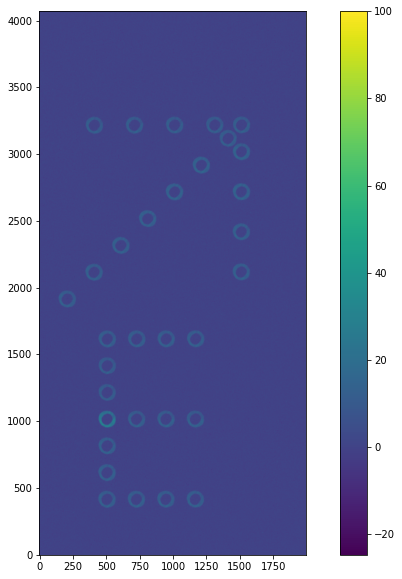

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp.image.array.T, origin='lower', vmax=100)
plt.colorbar()

Show all corner sensors: 

In [107]:
# Read all postISR images into  a dictionary 

images = {}

for ref in datasetRefs:
    print(ref.dataId)
    #print(ref.dataId.keys())
    postIsrExp = butler.get('postISRCCD', dataId=ref.dataId, collections=['run1'])
    images[ref.dataId['detector']] = postIsrExp


{instrument: 'LSSTCam', detector: 203, exposure: 4000021706002, ...}
{instrument: 'LSSTCam', detector: 199, exposure: 4000021706002, ...}
{instrument: 'LSSTCam', detector: 204, exposure: 4000021706002, ...}
{instrument: 'LSSTCam', detector: 196, exposure: 4000021706002, ...}
{instrument: 'LSSTCam', detector: 195, exposure: 4000021706002, ...}
{instrument: 'LSSTCam', detector: 191, exposure: 4000021706002, ...}
{instrument: 'LSSTCam', detector: 200, exposure: 4000021706002, ...}
{instrument: 'LSSTCam', detector: 192, exposure: 4000021706002, ...}


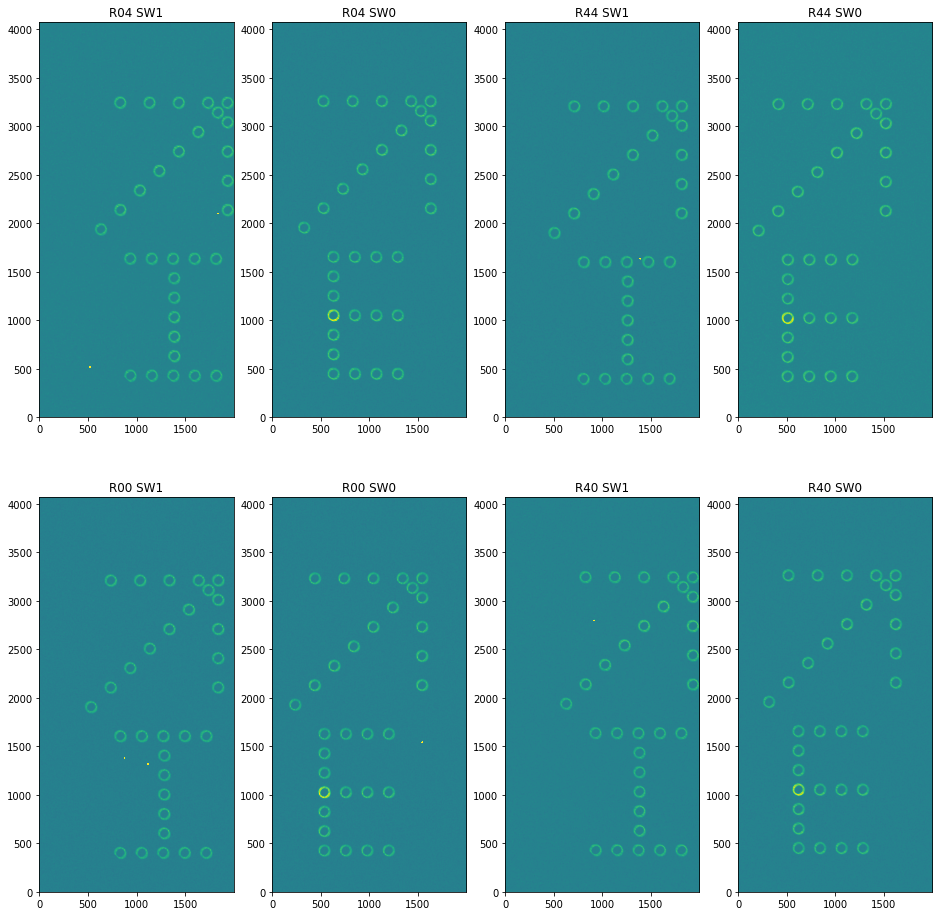

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.obs.lsst import LsstCam
import numpy as np 

camera = LsstCam.getCamera()

a = 4
fig,axs = plt.subplots(2,4,figsize=(4*a,4*a))
ax = np.ravel(axs)
i=0
for raftName in ['R04', 'R44', 'R00', 'R40']:
    for detectorName in ['SW1', 'SW0']:     
        detector = camera.get('%s_%s'%(raftName,detectorName))
        detectorId = detector.getId()
        image = images[detectorId].image.array
        ax[i].imshow(image.T, origin='lower',vmax=30)
        ax[i].set_title('%s %s'%(raftName, detectorName))
        i+=1 

(array([3.480000e+02, 9.148400e+04, 2.069346e+06, 4.650906e+06,
        1.214774e+06, 1.004980e+05, 1.455900e+04, 1.745000e+03,
        3.070000e+02, 3.300000e+01]),
 array([-23.476284 , -16.382704 ,  -9.289125 ,  -2.1955457,   4.898034 ,
         11.991613 ,  19.085194 ,  26.178772 ,  33.27235  ,  40.365932 ,
         47.45951  ], dtype=float32),
 <BarContainer object of 10 artists>)

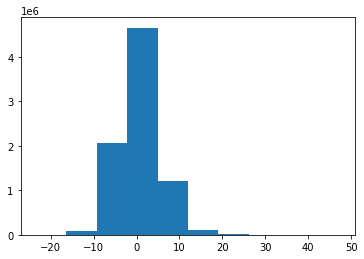

In [126]:
plt.hist(np.ravel(image))

# Fix the problem that obs_lsst was using an incorrect translator ... 

I encounter the problem - it's thinking it's LsstCam! ... 

Look at the header of the data repackaged with  : 
    
    cd /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/
    phosim_repackager.py /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/ --out_dir /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/ --prefix comcam --verbose

It passed the translator, but thinking it's an incorrect instrument : 

    translate_header.py -p lsst.obs.lsst.translators /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits 


    
    CC_H_20000217_006001_R22_S00.fits

In [29]:
a = 3.342345243
np.round(a,3)

3.342

In [2]:
from astropy.io import fits
hdul  = fits.open('/project/scichris/aos/segmentation_update/\
comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits')
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
EXPTIME =                  1.0                                                  
DARKTIME=                  1.0                                                  
RUNNUM  = '9006001 '                                                            
MJD-OBS =      51591.093522213                                                  
DATE-OBS= '2000-02-17T02:14:40.319'                                             
DAYOBS  = '20000217'                                                            
DATE    = '2021-03-17T04:01:14'                                                 
MJD     =    59290.16752314815                                                  
FILTER  = 'g       '        

But when I use `INSTRUME` = `comCam` , as in https://github.com/lsst/obs_lsst/blob/8e73630942fe3b02a1197fe71a8f965b7aba29dc/tests/headers/comCam-CC_C_20190530_000001_R22_S00.yaml  I get 

    translate_header.py -p lsst.obs.lsst.translators /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits 
    
    WARNING:root:This command is deprecated. Please use 'astrometadata translate'  or 'astrometadata dump' instead. See 'astrometadata -h' for more details.
    
    Analyzing /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits...
    
    Failure processing /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits: "Error calculating property 'detector_exposure_id' using translator <class 'lsst.obs.lsst.translators.phosim.LsstCamPhoSimTranslator'> and file /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits"
    
    Files with failed translations:
        /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits

Why does it even use `LsstCamPhoSimTranslator` ??? How can I make it to use `LsstComCam` tranlator...

Try  `LSSTComCam` as in `test_comCam_translator` : https://github.com/lsst/obs_lsst/blob/8e73630942fe3b02a1197fe71a8f965b7aba29dc/tests/test_translator.py

https://izziswift.com/set-matplotlib-colorbar-size-to-match-graph/ 

Also , I use the new command for translation , added by  https://jira.lsstcorp.org/browse/DM-28844
    
    astrometadata -p lsst.obs.lsst.translators translate /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits

## PR#298 to obs_lsst recognizing phosim-looking-like-comcam

Edit the part of https://github.com/lsst/obs_lsst/blob/8e73630942fe3b02a1197fe71a8f965b7aba29dc/python/lsst/obs/lsst/translators/phosim.py where it thinks that it's phosim if it has 'CREATOR:PHOSIM' or 'TESTTYPE:PHOSIM'... 

I tried removing `TESTTYPE: PHOSIM`, but because there is `CREATOR:PHOSIM` in each amp header, it picks it up regardless... So may be more expedient just adding the line 

    if "INSTRUME" in header:
        return False
Just like in https://github.com/lsst/obs_lsst/blob/8e73630942fe3b02a1197fe71a8f965b7aba29dc/python/lsst/obs/lsst/translators/comCam.py#L70 


So I do :

    cd /project/scichris/dev/obs_lsst
    git checkout -b tickets/DM-29264
    
And edit `translators/phosim.py`  - it worked! https://github.com/lsst/obs_lsst/pull/298

I run Jenkins - 

I go to https://ci.lsst.codes/blue/organizations/jenkins/stack-os-matrix/activity/ 
-> click "Run" in the top-left 
    -> enter "tickets/DM-29264" in the top box 
    -> enter "obs_lsst" in the second box (besides "lsst_distrib lsst_ci" ) ) 
    -> leave the "conda env ref" default


And in the end, leave the `INSTRUME` as `comCam`, because that's what the translator checks for : https://github.com/lsst/obs_lsst/blob/master/python/lsst/obs/lsst/translators/comCam.py#L81 

 
        if "INSTRUME" in header and "TELESCOP" in header:
          telescope = header["TELESCOP"]
          instrument = header["INSTRUME"].lower()
        if instrument == "comcam" and telescope in (SIMONYI_TELESCOPE, "LSST"):
          return True
          
        telcode = header.get("TELCODE", None)
        # Some lab data reports that it is LSST_CAMERA
        if telcode == "CC" and telescope in (SIMONYI_TELESCOPE, "LSST"):
           return True

# PR#13  to phosim_utils to enable repackaging of comcam

Do the rebase to the earliest commit for `phosim_utils`.

1) `git log` : 
    
    
        commit 3b15bfa39ecde4f012ee361eba6fd59ef84b5efa (HEAD -> tickets/DM-29264)
    Author: suberlak <sci.chris@gmail.com>
    Date:   Sat Mar 20 19:20:27 2021 +0000

        Initializing the repackager class with prefix

    commit 1c4e9b026c40142674a829a027f313be4c7789ea
    Author: suberlak <sci.chris@gmail.com>
    Date:   Sat Mar 20 19:19:03 2021 +0000

        Set testype back to PHOSIM

    commit 315993a8d68adeaa2f7f2a8f1dbb54e74750feb3
    Author: suberlak <sci.chris@gmail.com>
    Date:   Fri Mar 19 00:28:03 2021 +0000

        Fix rounding issue

    commit 138719eaa8db724408d233e47b7248af081fcf72
    Author: suberlak <sci.chris@gmail.com>
    Date:   Fri Mar 19 00:11:28 2021 +0000

        Update INSTRUME header for ComCam

    commit eac9febb0b5c99d60caf4dc3dc722d54b4790af5
    Author: suberlak <sci.chris@gmail.com>
    Date:   Thu Mar 18 20:54:07 2021 +0000

        More meaningful verbose messaging

    commit b4d2f4c56557fe116c88d414088e536222259c4b
    Author: suberlak <sci.chris@gmail.com>
    Date:   Wed Mar 17 19:00:31 2021 +0000

        Add handling of comcam

    commit 688629b9642a3523db2d9ade1a5988b60e653b83 (tag: v0.2, origin/master, origin/HEAD, tickets/DM-28919, master)
    Merge: b26ed09 8bcfb3f
    Author: Chris Suberlak <suberlak@uw.edu>
    Date:   Wed Mar 3 11:24:21 2021 -0800

    Merge pull request #12 from lsst-dm/tickets/DM-26836
    
    
2) Pick the earliest commit before the first in the PR, and do the rebase:

    git rebase -i 688629b
    
shows 
  
   
    pick b4d2f4c Add handling of comcam
    pick eac9feb More meaningful verbose messaging
    pick 138719e Update INSTRUME header for ComCam
    pick 315993a Fix rounding issue
    pick 1c4e9b0 Set testype back to PHOSIM
    pick 3b15bfa Initializing the repackager class with prefix

I squash all commits to the FIRST commit of the PR :


    pick b4d2f4c Add handling of comcam
    squash eac9feb More meaningful verbose messaging
    squash 138719e Update INSTRUME header for ComCam
    squash 315993a Fix rounding issue
    squash 1c4e9b0 Set testype back to PHOSIM
    squash 3b15bfa Initializing the repackager class with prefix

3) reset to put everything in clean state EXCEPT changing anything in the files (i.e. the files will have all the changes)

     git reset --soft HEAD~1
     git reset HEAD -- .

4) add / rm all test file changes as one commit . Then make single `add` , `commit` per python file . Now when I do `git log` I get : 

    commit f9dc231d7f092c4af04d7182bc94740fc777fa72 (HEAD -> tickets/DM-29264)
    Author: suberlak <sci.chris@gmail.com>
    Date:   Sat Mar 20 19:31:44 2021 +0000

        Add handling of comcam with appropriate camera, instrument, and telcode

    commit e529d49abd5d0bdf66758a570c97b964a806feb5
    Author: suberlak <sci.chris@gmail.com>
    Date:   Sat Mar 20 19:30:46 2021 +0000

        Pass prefix to class initialization 
    
5) push : 

    git push --force 

# Use the CC_ data (using LsstComCam mapper ) - problem with filters

    cd /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/gen3rpo
    
    
`testPipeline.yaml`  contains the only pipetask I want to run : the ISR 


    
    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstComCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          
          
`runIsr.sh` is a script that creates gen3 repo, registers an instrument, ingests raws, writes curated calibrations, and runs the pipetask defined with `testPipeline.yaml` script above: 

    #!/bin/bash

    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstComCam
    butler ingest-raws DATA /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits

    butler define-visits DATA/ lsst.obs.lsst.LsstComCam
    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstComCam

    pipetask run -j 9 -b DATA/ -i LSSTComCam/raw/all,LSSTComCam/calib \
        -p testPipeline.yaml --register-dataset-types --output-run run1
        
        
I execute these commands above one-by-one to see if it works : 




Check translation:

    astrometadata -p lsst.obs.lsst.translators translate /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits
    
Works fine ! 

So why `butler ingest-raws DATA /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/` yields


    ingest INFO: Successfully extracted metadata from 9 files with 0 failures
    ingest WARN: Exposure LSSTComCam:9006001 could not be registered: (sqlite3.IntegrityError) FOREIGN KEY constraint failed
    [SQL: INSERT INTO exposure (instrument, id, physical_filter, obs_id, exposure_time, dark_time, observation_type, observation_reason, day_obs, seq_num, group_name, group_id, target_name, science_program, tracking_ra, tracking_dec, sky_angle, zenith_angle, timespan_begin, timespan_end) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?) ON CONFLICT DO NOTHING]
    [parameters: ('LSSTComCam', 4000021706001, 'g', '9006001', 1.0, 1.0, 'science', 'test', 20000217, 6001, '4000021706001', 4000021706001, 'UNKNOWN', '9006001', None, None, None, None, 950753680319203134, 950753681319203134)]
    (Background on this error at: http://sqlalche.me/e/13/gkpj)
    ingest INFO: Successfully processed data from 0 exposures with 1 failure from exposure registration and 0 failures from file ingest.
    ingest INFO: Ingested 0 distinct Butler datasets
    Traceback (most recent call last):
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/daf_butler/21.0.0-49-ge0e32052+e6fd6d9ff9/bin/butler", line 28, in <module>
        sys.exit(main())
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/daf_butler/21.0.0-49-ge0e32052+e6fd6d9ff9/python/lsst/daf/butler/cli/butler.py", line 319, in main
        return cli()
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 829, in __call__
        return self.main(*args, **kwargs)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 782, in main
        rv = self.invoke(ctx)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 1259, in invoke
        return _process_result(sub_ctx.command.invoke(sub_ctx))
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 1066, in invoke
        return ctx.invoke(self.callback, **ctx.params)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 610, in invoke
        return callback(*args, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/cli/cmd/commands.py", line 114, in ingest_raws
        script.ingestRaws(*args, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/script/ingestRaws.py", line 73, in ingestRaws
        ingester.run(files, run=output_run, processes=processes)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/ingest.py", line 607, in run
        raise RuntimeError("Some failures encountered during ingestion")
    RuntimeError: Some failures encountered during ingestion
    
???

In [ ]:
I try `butler query-dimension-records DATA exposure` to see whats inside : 
    
    nothing! 
    
    
Try sqlite3:
    
    sqlite3 gen3.repo
    
    .tables
    .show 
    .schema exposure 
    
    SELECT * FROM exposure DESC LIMIT 10; 
    
    SELECT * FROM raw DESC LIMIT 10; 

The problem is that `butler` for `LsstComCam` does not recognize eg. `g` filter. I show the registered filters with 


    butler query-dimension-records DATA physical_filter
  
which shows for `LsstComCam` the following: 

    instrument   name    band 
    ---------- ------- -------
    LSSTComCam   empty   white
    LSSTComCam    g_01       g
    LSSTComCam    g_07       g
    LSSTComCam    i_06       i
    LSSTComCam    r_03       r
    LSSTComCam    u_02       u
    LSSTComCam    u_05       u
    LSSTComCam    u_06       u
    LSSTComCam unknown unknown
    LSSTComCam    y_04       y
    LSSTComCam    z_02       z
    LSSTComCam    z_03       z

So I try changing it by hand:
    
    

In [12]:
from astropy.io import fits
hdul  = fits.open('/project/scichris/aos/segmentation_update/\
comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits')
for i in range(1,len(hdul)):
    print(hdul[i].header['FILTER'])

g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01
g_01


In [13]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
EXPTIME =                  1.0                                                  
DARKTIME=                  1.0                                                  
RUNNUM  = '9006001 '                                                            
MJD-OBS =      51591.093522213                                                  
DATE-OBS= '2000-02-17T02:14:40.319'                                             
DAYOBS  = '20000217'                                                            
DATE    = '2021-03-17T04:01:14'                                                 
MJD     =    59290.16752314815                                                  
FILTER  = 'g_01    '        

In [10]:
for i in range(1,len(hdul)):
    hdul[i].header['FILTER'] = 'g_01'

In [4]:
hdul[0].header['FILTER'] = 'g_01'

In [11]:
hdul.writeto('/project/scichris/aos/segmentation_update/\
comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits', overwrite=True)

# ComCam - problem with boresight angle translation

Thn if I try 

    butler ingest-raws DATA /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits
    
    
it works : 


    ingest INFO: Successfully extracted metadata from 1 file with 0 failures
    ingest INFO: Exposure LSSTComCam:9006001 ingested successfully
    ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
    ingest INFO: Ingested 1 distinct Butler dataset

But at the next step:
    
    butler define-visits DATA/ lsst.obs.lsst.LsstComCam
    
I get 

    defineVisits INFO: Preprocessing data IDs.
    defineVisits INFO: Registering visit_system 1: by-group-metadata.
    defineVisits INFO: Grouping 1 exposure(s) into visits.
    defineVisits INFO: Computing regions and other metadata for 1 visit(s).
    Traceback (most recent call last):
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/daf_butler/21.0.0-49-ge0e32052+e6fd6d9ff9/bin/butler", line 28, in <module>
        sys.exit(main())
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/daf_butler/21.0.0-49-ge0e32052+e6fd6d9ff9/python/lsst/daf/butler/cli/butler.py", line 319, in main
        return cli()
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 829, in __call__
        return self.main(*args, **kwargs)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 782, in main
        rv = self.invoke(ctx)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 1259, in invoke
        return _process_result(sub_ctx.command.invoke(sub_ctx))
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 1066, in invoke
        return ctx.invoke(self.callback, **ctx.params)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/click/core.py", line 610, in invoke
        return callback(*args, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/cli/cmd/commands.py", line 94, in define_visits
        script.defineVisits(*args, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/script/defineVisits.py", line 61, in defineVisits
        task.run(butler.registry.queryDataIds(["exposure"], dataId={"instrument": instr.getName()}),
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 548, in run
        for visitRecords in allRecords:
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 467, in _buildVisitRecordsSingle
        return self._buildVisitRecords(args[0], collections=args[1])
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 361, in _buildVisitRecords
        visitRegion, visitDetectorRegions = self.computeVisitRegions.compute(definition,
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 786, in compute
        detectorBounds = self.computeExposureBounds(visit.exposures[0], collections=collections)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/obs_base/21.0.0-33-g5aae0e8+953e4345aa/python/lsst/obs/base/defineVisits.py", line 733, in computeExposureBounds
        orientation = lsst.geom.Angle(exposure.sky_angle, lsst.geom.degrees)
    TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
        1. lsst.geom.Angle(val: float, units: lsst.geom.AngleUnit = <lsst.geom.AngleUnit object at 0x7f829164eb70>)
        2. lsst.geom.Angle()

    Invoked with: None, <lsst.geom.AngleUnit object at 0x7f82916da030>

# Open PR to obs_lsst to fix comcam boresight translation

The above is because boresight translation was not allowed by default in lsstComCam https://github.com/lsst/obs_lsst/blob/52d8aac9fb5da2f52bfe105efd24dcded09ecce9/python/lsst/obs/lsst/translators/comCam.py#L47 . ; if I comment out the following lines

    diff --git a/python/lsst/obs/lsst/translators/comCam.py b/python/lsst/obs/lsst/translators/comCam.py
    index 13cf328..130ab92 100644
    --- a/python/lsst/obs/lsst/translators/comCam.py
    +++ b/python/lsst/obs/lsst/translators/comCam.py
    @@ -44,10 +44,10 @@ class LsstComCamTranslator(LsstCamTranslator):

         _const_map = {
             "instrument": "LSSTComCam",
    -        "boresight_rotation_coord": "unknown",
    -        "boresight_rotation_angle": None,
    -        "boresight_airmass": None,
    -        "tracking_radec": None,
    +        # "boresight_rotation_coord": "unknown",
    +        # "boresight_rotation_angle": None,
    +        # "boresight_airmass": None,
    +        # "tracking_radec": None,
         }

it works fine: 

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTComCam/raw/all
LSSTComCam/calib
LSSTComCam/calib/unbounded
run1
{instrument: 'LSSTComCam', detector: 0, exposure: 4000021706001, ...}
{instrument, detector, exposure}


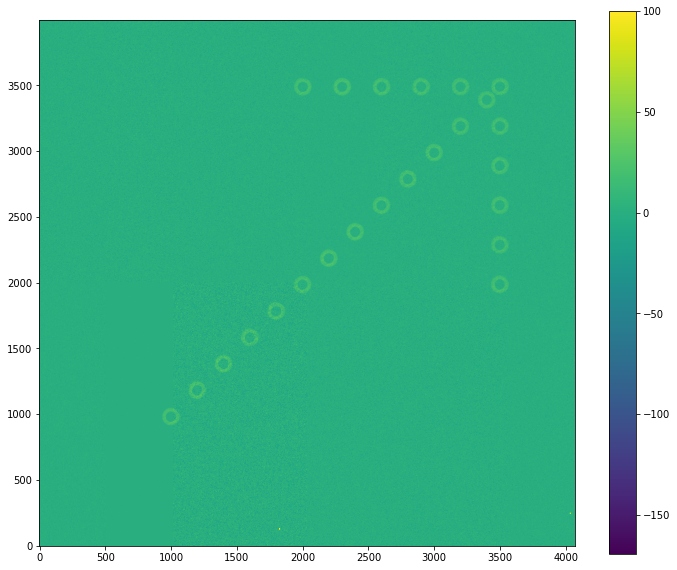

In [1]:

from lsst.daf import butler as dafButler
path_to_repo = "/project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/gen3rpo/DATA/"
butler = dafButler.Butler(path_to_repo)

registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    
for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())
    
dataId = datasetRefs[0].dataId

postIsrExp = butler.get('postISRCCD', dataId=dataId, collections=['run1'])

import matplotlib.pyplot as plt


%matplotlib inline
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp.image.array, origin='lower', vmax=100)
plt.colorbar()

I follow https://github.com/lsst/obs_lsst/commit/795469ba35c8ee359bac8cb8272a8c8f942d43e5 , also adding to  `test_translator.py` a `test_phoSimLsstComCam_translator` with `boresight_rotation_coord="sky"`, rather than `unknown`. (adding an appropriate yaml file to `tests/headers`).

    cd /project/scichris/dev/obs_lsst
    git checkout tickets/DM-29264
    git rebase -i master    # to ensure we are at the same stage as master
    
    # ==> open /python/lsst/obs/lsst/translators/comCam.py,
    # and remove the lines that needed to be commented away from _const_map()
    
    # edit the test_translator.py : 
    
    # add test_phosimComCam_translator() that would test the header of comCam-CC_H_... 
    
    

Need to take a comcam image, and take just the header, and save as yaml file, to look like eg. `tests/headers/lsstCam-MC_H...`)

In [2]:
from astropy.io import fits
dataRoot = '/project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged/CC_H_20000217_006001_R22_S00.fits'

hdul = fits.open(dataRoot)
header = hdul[0].header

header_dict = dict()
for key in header.keys():
    header_dict[key] = header[key]    

In [4]:
header_dict

{'SIMPLE': True,
 'BITPIX': 8,
 'NAXIS': 0,
 'EXTEND': True,
 'EXPTIME': 1.0,
 'DARKTIME': 1.0,
 'RUNNUM': '9006001',
 'MJD-OBS': 51591.093522213,
 'DATE-OBS': '2000-02-17T02:14:40.319',
 'DAYOBS': '20000217',
 'DATE': '2021-03-17T04:01:14',
 'MJD': 59290.16752314815,
 'FILTER': 'g_01',
 'LSST_NUM': 'ITL-3800C-229',
 'CCD_MANU': 'ITL',
 'CCD_TYPE': '3800C',
 'DETSIZE': '[1:4072,1:4000]',
 'INSTRUME': 'comCam',
 'TELESCOP': 'LSST',
 'TELCODE': 'CC',
 'CONTRLLR': 'H',
 'SEQNUM': 6001,
 'OBSID': 'CC_H_20000217_006001',
 'TESTTYPE': 'test',
 'IMGTYPE': 'SKYEXP',
 'RAFTBAY': 'R22',
 'CCDSLOT': 'S00',
 'RASTART': 0.0,
 'DECSTART': 0.0,
 'ROTSTART': 0.0,
 'RA': 0.0,
 'DEC': 0.0,
 'ROTPA': 0.0,
 'ROTCOORD': 'sky',
 'AMSTART': 1.24813143788881,
 'ELSTART': 53.244268}

In [6]:
import yaml

In [8]:
filePath = '/project/scichris/dev/obs_lsst/tests/headers/comCam-CC_H_20000217_006001_R22_S00.yaml'
with open(filePath, 'w') as file:
    documents = yaml.dump(header_dict, file)

Problem with  existing tests : `comCam-CC_C_20190530_000001_R22_S00.yaml` 

astrometadata -p lsst.obs.lsst.translators translate tests/headers/comCam-CC_C_20190530_000001_R22_S00.yaml

works fine :
    
    Analyzing tests/headers/comCam-CC_C_20190530_000001_R22_S00.yaml...
    WARNING:lsst.obs.lsst.translators.comCam:tests/headers/comCam-CC_C_20190530_000001_R22_S00.yaml(CC_C_20190530_000001): replaced FILTER None with "unknown"
    instrument: LSSTComCam
    telescope: Simonyi Survey Telescope
    datetime_begin: 2019-05-31T02:38:37.384
    altaz_begin: None
    boresight_airmass: None
    boresight_rotation_angle: nan deg
    boresight_rotation_coord: unknown
    dark_time: 0.398 s
    datetime_end: 2019-05-31T02:38:37.384
    detector_exposure_id: 3019053000001000
    detector_group: R22
    detector_name: S00
    detector_num: 0
    detector_serial: ITL-3800C-229
    detector_unique_name: R22_S00
    exposure_group: 3019053000001
    exposure_id: 3019053000001
    exposure_time: 0.0 s
    location: None
    object: UNKNOWN
    observation_counter: 1
    observation_id: CC_C_20190530_000001
    observation_reason: bias
    observation_type: bias
    observing_day: 20190530
    physical_filter: unknown
    pressure: None
    relative_humidity: None
    science_program: unknown
    temperature: None
    tracking_radec: None
    visit_id: 3019053000001

In [ ]:
but 
     astrometadata -p lsst.obs.lsst.translators translate tests/headers/comCam-CC_C_20190526_000223_R22_S01.yaml

yields an error: 
    
     Analyzing tests/headers/comCam-CC_C_20190526_000223_R22_S01.yaml...
WARNING:lsst.obs.lsst.translators.comCam:tests/headers/comCam-CC_C_20190526_000223_R22_S01.yaml(CC_C_20190526_000223): replaced FILTER None with "unknown"
Failure processing tests/headers/comCam-CC_C_20190526_000223_R22_S01.yaml: "Error calculating property 'boresight_rotation_angle' using translator <class 'lsst.obs.lsst.translators.comCam.LsstComCamTranslator'> and file tests/headers/comCam-CC_C_20190526_000223_R22_S01.yaml"
Files with failed translations:
        tests/headers/comCam-CC_C_20190526_000223_R22_S01.yaml

When I call

   astrometadata -p lsst.obs.lsst.translators translate tests/headers/comCam-CC_C_20190526_000223_R22_S01.yaml 
    
It executes https://github.com/lsst/astro_metadata_translator/blob/master/bin.src/translate_header.py , which calls https://github.com/lsst/astro_metadata_translator/blob/master/python/astro_metadata_translator/bin/translateheader.py


It determines translation class here https://github.com/lsst/astro_metadata_translator/blob/ffa9b84d570c9dda240a820310bb6db86361a961/python/astro_metadata_translator/translator.py#L443   , which in turn calls 

https://github.com/lsst/astro_metadata_translator/blob/05ce667d1b397c2f18efa33ad0b5bcf031f1dfe0/python/astro_metadata_translator/observationInfo.py


that iterates over a list of properties calling translator class:

https://github.com/lsst/astro_metadata_translator/blob/05ce667d1b397c2f18efa33ad0b5bcf031f1dfe0/python/astro_metadata_translator/observationInfo.py#L150-L157

    which astrometadata
    
shows me where it resides:

    /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/astro_metadata_translator/0.1.0-22-g86269e8+6691386486/bin/astrometadata
    
but since I can't write there , I go to 

    cd /project/scichris/dev/astro_metadata_translator
    
    git checkout master
    git pull
    
    git checkout -b debug
    # here I add print statements to observationInfo.py 
    
    
Try 

    astrometadata -p lsst.obs.lsst.translators translate /project/scichris/dev/obs_lsst/tests/headers/comCam-CC_C_20190526_000223_R22_S01.yaml 

    pydoc lsst.obs.lsst.translators.LsstComCamTranslator 

shows which methods are defined there : 



I made a new ticket for that work : https://jira.lsstcorp.org/browse/DM-29424
        
Thus I checkout to that branch :
    
    git checkout master
    git pull  # to ensure we have all the updates
    
    
    git checkout -b  tickets/DM-29424  # making a new branch 
    
    # add and commit all changed files 
    
    scons # to ensure it passes
  

It turns out it actually fails `test_ingest.py` ! I don't really know why... 

  
    git push 
    

Then check on Jenkins: I go to https://ci.lsst.codes/blue/organizations/jenkins/stack-os-matrix/activity/ 
* click "Run" in the top-left 
* enter "tickets/DM-29424" in the top box 
* enter "obs_lsst" in the second box (besides "lsst_distrib lsst_ci" ) ) 
* leave the "conda env ref" default

  
    git push 
    

Then check on Jenkins: I go to https://ci.lsst.codes/blue/organizations/jenkins/stack-os-matrix/activity/ 
* click "Run" in the top-left 
* enter "tickets/DM-29424" in the top box 
* enter "obs_lsst" in the second box (besides "lsst_distrib lsst_ci" ) ) 
* leave the "conda env ref" default## Adding LsstComCam to  phosim_utils: PR#13
    
    * adding usage of LsstComCam
    * changing --prefix to --inst , and prefix to instName 
    * updating docstrings and comment strings
    * updating all strings to f-strings
    
    
Added all commits after revision. Now clean up:
    
    
1) rebase to the latest commit just before the first commit of the ticket branch  : 
    
    git rebase -i [latestCommintJustBeforefirstCommitOfTicketBranch]

2) squash all commits to the FIRST commit of the PR :
    
    pick e529d49 Pass prefix to class initialization
    s f9dc231 Add handling of comcam with appropriate camera, instrument, and telcode
    s 63cabe1 fix import of LsstComCam
    s 53240a6 clarify controller comment
    s 7795539 change --prefix to --inst
    s 5466074 change prefix to instName in the main repackager
    s b4fa1e2 add else condition to class initialization if prefix not lsst or comcam
    s f640245 update each docstring with default values and whether optional
    s 1d433b0 changed string formatting to f-strings
    s f99e471 update comment string for SEQNUM
    s d70ab16 update OBSID formatting and comment
    s 0006ca0 corrected OBSID formatting
    s 6a795b0 reformat by black
    squash 2e70910 updated tests


3) reset to put everything in clean state EXCEPT changing anything in the files (i.e. the files will have all the changes)

     git reset --soft HEAD~1
     git reset HEAD -- .

4) add / rm all test file changes as one commit . Then make single `add` , `commit` per python file 

5) push : 

    git push --force 

In [ ]:
Need to update unit tests. That would include repackaging comcam amp and e-image

First, threshold comcam amp images in `/project/scichris/aos/segmentation_update/comcam/arrows_DM-29264`:
    
    thresholdFits.py  comcam_a_9006001_f1_R22_S20*
    
    
Show the thresholded image: 

In [4]:
from astropy.io import fits

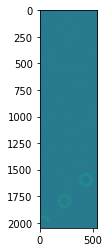

In [44]:

fname = 'comcam_a_9006001_f1_R22_S20_C03_E000.fits.gz'
hdul = fits.open(f'/project/scichris/aos/segmentation_update/\
comcam/arrows_DM-29264/{fname}')
import matplotlib.pyplot as plt
plt.imshow(hdul[0].data,vmin=900,vmax=1100)

(array([5.90000e+01, 1.83800e+03, 2.58990e+04, 1.47520e+05, 3.60962e+05,
        3.93489e+05, 1.53945e+05, 2.80780e+04, 2.23900e+03, 8.30000e+01]),
 array([ 937. ,  952.2,  967.4,  982.6,  997.8, 1013. , 1028.2, 1043.4,
        1058.6, 1073.8, 1089. ]),
 <BarContainer object of 10 artists>)

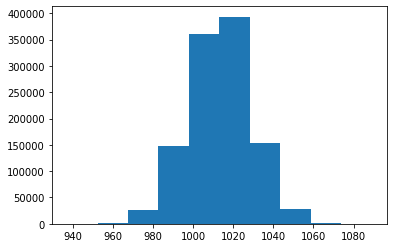

In [21]:
import numpy as np 
plt.hist(np.ravel(hdul[0].data))

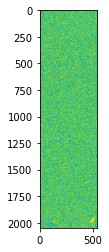

In [37]:
hdul = fits.open(f'/project/scichris/aos/segmentation_update/\
comcam/arrows_DM-29264/thresholded/{fname}')
import matplotlib.pyplot as plt
plt.imshow(hdul[0].data, vmin=0, vmax=1)

In [26]:
hdul[0].data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [ ]:
Copy the thresholded files to test image location:
    
    cd /project/scichris/aos/phosim_utils/tests/testData/amp
    cp /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/thresholded/comcam_a_* .
    
    cd /project/scichris/aos/phosim_utils/tests/testData/eimage
    cp /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/comcam_e_9006001_f1_R22_S20_E000.fits.gz .

Develop tests for repackaging the amp image and e-image : 
    
    

In [48]:
from lsst.phosim.utils.phosim_repackager import PhoSimRepackager
from lsst.utils import getPackageDir
import os
import shutil
import astropy.io.fits as fits
import unittest
import glob

package_dir = getPackageDir("phosim_utils")
phoSim_repackager = PhoSimRepackager()

test_dir = os.path.join(package_dir, "tests")
tmp_test_dir = os.path.join(test_dir, "tmp")

if not os.path.exists(tmp_test_dir):
    os.makedirs(tmp_test_dir)
    
test_data_dir_eimg = os.path.join(test_dir, "testData", "eimage")
test_data_dir_amp = os.path.join(test_dir, "testData", "amp")

base_eimg_file_name = "lsst_e_9006001_f1_R22_S22_E000.fits"
repackaged_eimg_file_name = "MC_H_20000217_006001_R22_S22_e.fits"
repackaged_amp_file_name = "MC_H_20000217_006001_R22_S22.fits"


base_eimg_file_name_comcam = "comcam_e_9006001_f1_R22_S20_E000.fits"
repackaged_eimg_file_name_comcam = "CC_H_20000217_006001_R22_S20_e.fits"
repackaged_amp_file_name_comcam = "CC_H_20000217_006001_R22_S20.fits"

eimg_file_path = os.path.join(
test_data_dir_eimg, "%s.gz" %base_eimg_file_name)
amp_file_paths = sorted(glob.glob(os.path.join(test_data_dir_amp,
                                     'lsst_a_*')))

eimg_file_path_comcam = os.path.join(
test_data_dir_eimg, "%s.gz" % base_eimg_file_name_comcam)
amp_file_paths_comcam = sorted(glob.glob(os.path.join(test_data_dir_amp,
                                            'comcam_a_*')))

In [51]:
# def test_repackage_eimage_comcam()
phoSim_repackager_comcam = PhoSimRepackager('comcam')
phoSim_repackager_comcam.repackage_eimage(eimg_file_path_comcam, out_dir=tmp_test_dir)

Repackaging sensor R22_S20
Saved as /project/scichris/aos/phosim_utils/tests/tmp/CC_H_20000217_006001_R22_S20_e.fits


In [54]:
phoSim_repackager_comcam.CONTRLLR

'H'

In [55]:
file_name = repackaged_eimg_file_name_comcam
# def _check_repackaged_eimg_file_comcam
eimg_file = os.path.join(tmp_test_dir, file_name)
hdul = fits.open(eimg_file)
sensor = hdul[0]

In [56]:
sensor.data.shape

(4000, 4072)

In [57]:
header = sensor.header

In [58]:
header["RAFTBAY"]

'R22'

In [59]:
header["CCDSLOT"]

'S20'

In [60]:
header["RA"]

0.0

In [65]:
if not os.path.exists(tmp_test_dir):
    os.makedirs(tmp_test_dir)

In [66]:
os.listdir(tmp_test_dir)

[]

In [67]:
# test_repackage_amp_image_comcam
phoSim_repackager_comcam.repackage(
        amp_file_paths_comcam, out_dir=tmp_test_dir
        )

Repackaging sensor R22_S20
Saved as /project/scichris/aos/phosim_utils/tests/tmp/CC_H_20000217_006001_R22_S20.fits


In [68]:
os.listdir(tmp_test_dir)

['CC_H_20000217_006001_R22_S20.fits']

In [69]:
file_name = repackaged_amp_file_name_comcam

# _check_repackaged_amp_file_comcam(file_name)
amp_file = os.path.join(tmp_test_dir, file_name)
hdul = fits.open(amp_file)

In [70]:
hdul[1].data.shape

(2048, 544)

In [71]:
len(hdul)

17

In [72]:
header = hdul[0].header

In [73]:
header["RAFTBAY"]

'R22'

In [74]:
header["CCDSLOT"]

'S20'

In [75]:
header["LSST_NUM"]

'ITL-3800C-319'

In [76]:
header["OBSID"]

'CC_H_20000217_006001'

In [77]:
header["RA"]

0.0

In [78]:
header = hdul[1].header

In [79]:
header["AMPID"]

'C10'

In [80]:
header["CCDID"]

'R22_S20'

In [81]:
header["EXTNAME"]

'Segment10'

Update the tag 

In [ ]:

    git checkout master
    git pull 
    git tag -ln   # shows all tags 
    
    git tag -a v0.2.1 
    
    # if I want to change the tag
    git tag -fa v0.2.1 
    
    # enter message : 
    Merge pull request #13 from lsst-dm/tickets/DM-29264
    Tickets/DM-29264: Add handling of comcam
    
    git push origin --tags 

In [ ]:

    git checkout master
    git pull 
    git tag -ln   # shows all tags 
    
    git tag -a v0.2.2 
    
    # if I want to change the tag
    git tag -fa v0.2.2
    
    # enter message : 
    Merge pull request #14 from lsst-dm/tickets/DM-29264
    DM-29264: Update comCam header
    
    git push origin --tags 

### A new PR to phosim_utils to update `FILTER` header (PR#14) 

    git checkout tickets/DM-29264

    git merge master #  (to grab the tag)

The filter names for lsstCam are fine, but for lsstComCam need to be as in https://github.com/lsst/obs_lsst/blob/master/python/lsst/obs/lsst/filters.py : 
    
        if instName == InstName.COMCAM:
        # use the mapping `g` --> `g_01`, etc 
    else: 
       # LSST or LSSTFAM : keep filters 
       # as `g` or `u` - unchanged 
       
These weird names come from https://jira.lsstcorp.org/browse/DM-21706  : 

    band thickness serial notes

    u-band  7mm SN-05 incorrect sub thickness

    g-band  9mm SN-07 first run, bad cosmetics

    g-band 9mm SN-01  second run, slightly better cosmetics

    r-band  9mm SN-03 

    i-band  7mm SN-06

    z-band  7mm SN-03

    z-band 7mm SN-02 failed spec

    y-band  7mm SN-04



    Among these will be another u-band (will be known in the next couple months):

    clear 9mm SN-02

    clear 9mm SN-06
    
That's why in `filters.py` we have 

     for band, sn in [("u", "SN-05"),  # incorrect sub thickness
                     ("u", "SN-02"),  # not yet coated
                     ("u", "SN-06"),  # not yet coated
                     ("g", "SN-07"),  # bad cosmetics
                     ("g", "SN-01"),
                     ("r", "SN-03"),
                     ("i", "SN-06"),
                     ("z", "SN-03"),
                     ("z", "SN-02"),  # failed specs
                     ("y", "SN-04"),
                     ]:
        physical_filter = f"{band}_{sn[3:]}"
        
I decide to use `u_06`, `g_01`, `r_03` ,  `i_06` , `z_02`, `y_04` 




Does e-image header even have a filter ? 

In [83]:
hdul = fits.open('/project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/comcam_e_9006001_f1_R22_S20_E000.fits.gz')

In [85]:
hdul[0].header['FILTER']

'g'

Try repackaging .. 

    phosim_repackager.py /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/ --out_dir /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged2/ --prefix comcam --verbose


Try ingesting into gen3 repo: 
    
    cd /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/gen3rpo
    setup -k -r /project/scichris/dev/obs_lsst  # to ensure we're using the version where  I enabled boresight translation 
    
    
    butler create DATA2
    butler register-instrument DATA2/ lsst.obs.lsst.LsstComCam
    butler ingest-raws DATA2 /project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/repackaged2/CC_H_20000217_006001_R22_S00.fits

    butler define-visits DATA2/ lsst.obs.lsst.LsstComCam
    butler write-curated-calibrations DATA2/ lsst.obs.lsst.LsstComCam
    
    pipetask run -j 9 -b DATA2/ -i LSSTComCam/raw/all,LSSTComCam/calib \
    -p testPipeline.yaml --register-dataset-types --output-run run1

It worked! Show the postISR image:  

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTComCam/raw/all
LSSTComCam/calib
LSSTComCam/calib/unbounded
run1
{instrument: 'LSSTComCam', detector: 0, exposure: 4000021706001, ...}
{instrument, detector, exposure}


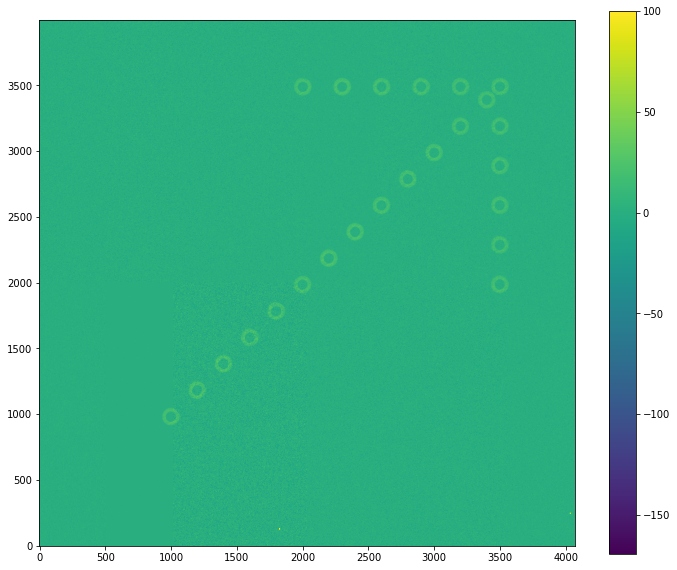

In [86]:

from lsst.daf import butler as dafButler
path_to_repo = "/project/scichris/aos/segmentation_update/comcam/arrows_DM-29264/gen3rpo/DATA2/"
butler = dafButler.Butler(path_to_repo)

registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    
for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())
    
dataId = datasetRefs[0].dataId

postIsrExp = butler.get('postISRCCD', dataId=dataId, collections=['run1'])

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp.image.array, origin='lower', vmax=100)
plt.colorbar()

In [88]:
from lsst.phosim.utils.phosim_repackager import translate_comcam_filter

ImportError: cannot import name 'translate_comcam_filter' from 'lsst.phosim.utils.phosim_repackager' (/project/scichris/aos/phosim_utils/python/lsst/phosim/utils/phosim_repackager.py)

In [1]:
from lsst.phosim.utils.phosim_repackager import (
    PhoSimRepackager,
    updateComCamSpecificData,
)


In [4]:
import glob
import os
from lsst.utils import getPackageDir

package_dir = getPackageDir("phosim_utils")
test_dir = os.path.join(package_dir, "tests")
test_data_dir_amp = os.path.join(test_dir, "testData", "amp")
amp_file_paths_comcam = sorted(
            glob.glob(os.path.join(test_data_dir_amp, "comcam_a_*")))

In [9]:
from astropy.io import fits
hdul = fits.open(amp_file_paths_comcam[0])

In [11]:
hdul[0].header["FILTER"]

'g'

In [12]:
fits.HDUList(fits.PrimaryHDU())

In [25]:
a

FILTER  = 'g       '                                                            

In [22]:
a["FILTER"] = 'g'
a = updateComCamSpecificData(a)

FILTER  = 'g_01    '                                                            